## Import libraries

In [35]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from functools import reduce

# Things to consider
* Land density
* Weather
* Season
* Race

##  Read in Air Quality Measures CSV (Contains PM2.5 levels):

In [37]:
df = pd.read_csv('Air_Quality_Measures_on_the_National_Environmental_Health_Tracking_Network.csv', encoding = "'ISO-8859-1")

## Rename columns and Drop unneccessary ones (Do not re-run):

In [38]:
df.rename(index=str, columns={"CountyName": "County", "StateName": "State",}, inplace=True)
df.drop(['MeasureId','MeasureType', 'StratificationLevel', 'StateFips', 'CountyFips', 'Unit', 'UnitName', 'DataOrigin', 'MonitorOnly'], axis=1, inplace=True)

In [39]:
#View Column Names
df.columns

Index(['MeasureName', 'State', 'County', 'ReportYear', 'Value'], dtype='object')

## Change 'ReportYear' to date_time data type

In [40]:
#Convert Year to Datetime Object
df['ReportYear']=pd.to_datetime(df['ReportYear'], format='%Y')

In [41]:
df.head()

,MeasureName,State,County,ReportYear,Value
0,Number of days with maximum 8-hour average ozo...,Alabama,Clay,1999-01-01,33.0
1,Number of days with maximum 8-hour average ozo...,Alabama,Elmore,1999-01-01,5.0
2,Number of days with maximum 8-hour average ozo...,Alabama,Jefferson,1999-01-01,39.0
3,Number of days with maximum 8-hour average ozo...,Alabama,Lawrence,1999-01-01,28.0
4,Number of days with maximum 8-hour average ozo...,Alabama,Madison,1999-01-01,31.0


## Change "Measure Names" with numerical codes
* Allowed me to filter out the measure names I didn't need using code

In [42]:
measure_names=['Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard',
              'Number of person-days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard',
              'Person-days with PM2.5 over the National Ambient Air Quality Standard',
              'Percent of days with PM2.5 levels over the National Ambient Air Quality Standard (NAAQS)',
              'Annual average ambient concentrations of PM2.5 in micrograms per cubic meter (based on seasonal averages and daily measurement)',
              'Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data)',
              'Number of person-days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data)',
              'Percent of days with PM2.5 levels over the National Ambient Air Quality Standard (monitor and modeled data)',
              'Number of person-days with PM2.5 over the National Ambient Air Quality Standard (monitor and modeled data)',
              'Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter, based on seasonal averages and daily measurement (monitor and modeled data)']
numbers=list(range(1,11))
new_df=df.replace(measure_names, numbers)

In [43]:
new_df.head()

,MeasureName,State,County,ReportYear,Value
0,1,Alabama,Clay,1999-01-01,33.0
1,1,Alabama,Elmore,1999-01-01,5.0
2,1,Alabama,Jefferson,1999-01-01,39.0
3,1,Alabama,Lawrence,1999-01-01,28.0
4,1,Alabama,Madison,1999-01-01,31.0


## Measure 10 County Avg Rankings 
* 10: 'Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter, based on seasonal averages and daily measurement (monitor and modeled data)'

In [44]:
measure10=new_df[new_df['MeasureName'] == 10]
new_value_avg10=measure10.groupby(['State','County'], as_index=False).mean().sort_values(by='Value', ascending=False)
new_value_avg10.head(10)

,State,County,MeasureName,Value
189,California,Riverside,10,20.541063
175,California,Los Angeles,10,19.880742
192,California,San Bernardino,10,19.494277
2211,Pennsylvania,Allegheny,10,19.398811
171,California,Kern,10,19.345668
36,Alabama,Jefferson,10,17.720868
166,California,Fresno,10,17.401051
210,California,Tulare,10,17.315409
708,Indiana,Lake,10,16.773923
172,California,Kings,10,16.501265


## Measure 6 County Avg Rankings 
* 6: 'Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data)'

In [45]:
measure6=new_df[new_df['MeasureName'] == 6]
new_value_avg6=measure6.groupby(['State','County'], as_index=False).mean().sort_values(by='Value', ascending=False)
new_value_avg6.head(10)

,State,County,MeasureName,Value
192,California,San Bernardino,6,114.090909
189,California,Riverside,6,107.636364
171,California,Kern,6,105.090909
210,California,Tulare,6,104.545455
175,California,Los Angeles,6,86.272727
166,California,Fresno,6,78.363636
165,California,El Dorado,6,42.636364
2589,Texas,Harris,6,40.363636
180,California,Merced,6,39.909091
185,California,Nevada,6,39.272727


## All County Asthma Csv's

In [46]:
all_files = ['AZ_Asthma.csv', 'Cali_Asthma.csv', 'Colorado_Asthma.csv', 'CT_Asthma.csv', 'FL_Asthma.csv', 'Iowa_Asthma.csv', 'Kansas_Asthma.csv', 'Kentucky_Asthma.csv', 'Louisiana_Asthma.csv','MD_asthma.csv', 'Maine_Asthma.csv', 'Mass_asthma.csv', 'Minn_Asthma.csv', 'Missouri_Asthma.csv', 'NC_Asthma.csv','NJ_asthma.csv','NY_Asthma.csv', 'NewHamp_Asthma.csv', 'NewMex_Asthma.csv', 'RI_Asthma.csv', 'SC_Asthma.csv', 'Tenn_Asthma.csv', 'Utah_Asthma.csv', 'Vermont_Asthma.csv', 'Wisconsin_Asthma.csv']
li = []

for filename in all_files:
    mad_df = pd.read_csv(filename, index_col=None, header=0)
    li.append(mad_df)

all_states = pd.concat(li, axis=0, ignore_index=True)
all_states.drop(['Unnamed: 6','countyFIPS', 'stateFIPS'], axis=1, inplace=True)


In [47]:
new_all_states=all_states.drop(['Year'], axis=1)
new_all_states.rename(index=str, columns={"Value": "Yearly_Asthma_EDVisits"}, inplace=True)

In [48]:
new_all_states['Yearly_Asthma_EDVisits']=new_all_states['Yearly_Asthma_EDVisits'].str.replace(',', '')
new_all_states['Yearly_Asthma_EDVisits']= pd.to_numeric(new_all_states['Yearly_Asthma_EDVisits'], errors ='coerce')

# All Population CSVs

In [49]:
population_files = ['Colorado_pop.csv', 'AZ_pop.csv','Cali_pop.csv', 'CT_pop.csv', 'FL_pop.csv', 'Iowa_pop.csv', 'Kansas_pop.csv', 'Kentucky_pop.csv', 'Utah_pop.csv', 'Louisiana_pop.csv', 'Maine_pop.csv', 'MD_pop.csv', 'Mass_pop.csv', 'Minn_pop.csv', 'NY_pop.csv', 'Missouri_pop.csv', 'NC_pop.csv', 'NewHamp_pop.csv', 'NJ_pop.csv', 'NewMex_pop.csv', 'RI_pop.csv', 'SC_pop.csv', 'Tenn_pop.csv', 'Vermont_pop.csv', 'Wisconsin_pop.csv']
popli = []

for popfile in population_files:
    mad_df = pd.read_csv(popfile, index_col=None, header=0)
    popli.append(mad_df)

all_pop = pd.concat(popli, axis=0, ignore_index=True)
all_pop.drop(['Unnamed: 6','countyFIPS', 'stateFIPS'], axis=1, inplace=True)

In [50]:
new_all_pop=all_pop.drop(['Year'], axis=1)
new_all_pop.rename(index=str, columns={"Value": "Population"}, inplace=True)

In [51]:
new_all_pop['Population']=new_all_pop['Population'].str.replace(',', '')
new_all_pop['Population']= pd.to_numeric(new_all_pop['Population'], errors ='coerce')

## Merge and Play with all three dataframes from value 6

In [61]:
dfs_all = [new_value_avg6, new_all_states, new_all_pop]
df_six = reduce(lambda left,right: pd.merge(left,right,on=['State','County']), dfs_all)

In [63]:
df_six.head()

,State,County,MeasureName,Value,Yearly_Asthma_EDVisits,Population
0,California,San Bernardino,6,114.090909,11352.0,1596584
1,California,San Bernardino,6,114.090909,11352.0,1618438
2,California,San Bernardino,6,114.090909,11352.0,1646304
3,California,San Bernardino,6,114.090909,11352.0,1681601
4,California,San Bernardino,6,114.090909,11352.0,1718037


## Rename df_six (Do not re-run)

In [64]:
df_six.rename(index=str, columns={"Value": "Avg_Days_Over"}, inplace=True)

## Merge and Play with all three dataframes from value 10

In [65]:
df_10=pd.merge(df_six, new_value_avg10, on=['State','County'])


## ## Rename df_10 (Do not re-run)

In [66]:
df_10.rename(index=str, columns={"Value": "PM2.5_Annual_Avg"}, inplace=True)

In [33]:
new_united10.drop(['MeasureName_x','MeasureName_y'], axis=1, inplace=True)
new_united10['Avg_Days_Over']=new_united10['Avg_Days_Over'].round()
new_united10['Yearly_Asthma_EDVisits']=new_united10['Yearly_Asthma_EDVisits'].round()
new_united10['Population']=new_united10['Population'].round()
new_united10['PM2.5_Annual_Avg']=new_united10['PM2.5_Annual_Avg'].round()

NameError: name 'new_united10' is not defined

In [67]:
new_united10.head()

,State,County,Avg_Days_Over,Yearly_Asthma_EDVisits,Population,PM2.5_Annual_Avg
0,California,San Bernardino,114.0,12050.0,1899318.0,19.0
1,California,Riverside,108.0,9079.0,1911108.0,21.0
2,California,Kern,105.0,4473.0,760124.0,19.0
3,California,Tulare,105.0,2388.0,407989.0,17.0
4,California,Los Angeles,86.0,48164.0,9707171.0,20.0


In [68]:
new_united10['A_Visits/Pop']=(new_united10['Yearly_Asthma_EDVisits']/new_united10['Population']).round(2)

In [69]:
prod_features = ['A/Pop_Avg-PM2.5_lvl', 'Yearly_AVisits_Avg-PM2.5_lvl']

united_features = (new_united10.groupby(['PM2.5_Annual_Avg'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('A_Visits/Pop','mean'),
                                                   ('Yearly_Asthma_EDVisits','mean')])))
united_features.columns = ['PM2.5_Annual_Avg'] + prod_features
united_features['A/Pop_Avg-PM2.5_lvl']=united_features['A/Pop_Avg-PM2.5_lvl'].round(4)
united_features.head(5)

,PM2.5_Annual_Avg,A/Pop_Avg-PM2.5_lvl,Yearly_AVisits_Avg-PM2.5_lvl
0,5.0,0.0000,14.166667
1,6.0,0.0011,53.818182
2,7.0,0.0019,250.209677
3,8.0,0.0021,409.808989
4,9.0,0.0029,669.127451


In [70]:
new_united10=pd.merge(new_united10, united_features, on='PM2.5_Annual_Avg')

In [71]:
new_united10['Yearly_AVisits_Avg-PM2.5_lvl']=new_united10['Yearly_AVisits_Avg-PM2.5_lvl'].round()

In [72]:
new_united10.sort_values(by = 'A/Pop_Avg-PM2.5_lvl', ascending = False).head(5)

,State,County,Avg_Days_Over,Yearly_Asthma_EDVisits,Population,PM2.5_Annual_Avg,A_Visits/Pop,A/Pop_Avg-PM2.5_lvl,Yearly_AVisits_Avg-PM2.5_lvl
0,California,San Bernardino,114.0,12050.0,1899318.0,19.0,0.01,0.01,8262.0
1122,Kentucky,Jefferson,14.0,6276.0,719554.0,16.0,0.01,0.01,6276.0
3,California,Tulare,105.0,2388.0,407989.0,17.0,0.01,0.01,3439.0
4,California,Fresno,78.0,6759.0,872261.0,17.0,0.01,0.01,3439.0
5,California,Kings,39.0,1169.0,140771.0,17.0,0.01,0.01,3439.0


In [73]:
new_united10['At_Risk']=new_united10['A_Visits/Pop'].apply(lambda x: 0 if x < .01 else 1)

In [74]:
new_united10.drop(6, inplace=True)

In [75]:
new_united10.drop(['State','County'], axis=1, inplace=True)

In [76]:
new_united10.dropna(inplace=True)

# Train, Test, Split (Forreal)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(new_united10.iloc[:, 0:7], new_united10.iloc[:, -1].values.reshape(-1,1), 
                                                    test_size = 0.2, random_state=42)

In [78]:
train_df = X_train.copy()
test_df = X_test.copy()
train_df['At_Risk'] = y_train
test_df['At_Risk'] = y_test

# Create Column for those going to Hospital 
train_df['Going?'] = train_df['At_Risk'].apply(lambda x: (x and 'Yes') or 'No')
train_df.head(5)

,Avg_Days_Over,Yearly_Asthma_EDVisits,Population,PM2.5_Annual_Avg,A_Visits/Pop,A/Pop_Avg-PM2.5_lvl,Yearly_AVisits_Avg-PM2.5_lvl,At_Risk,Going?
171,2.0,24.0,9052.0,11.0,0.0,0.0026,537.0,0,No
725,6.0,155.0,40198.0,12.0,0.0,0.0050,740.0,0,No
633,3.0,71.0,18278.0,13.0,0.0,0.0053,804.0,0,No
210,2.0,85.0,17158.0,11.0,0.0,0.0026,537.0,0,No
375,5.0,1309.0,359054.0,9.0,0.0,0.0029,669.0,0,No


/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


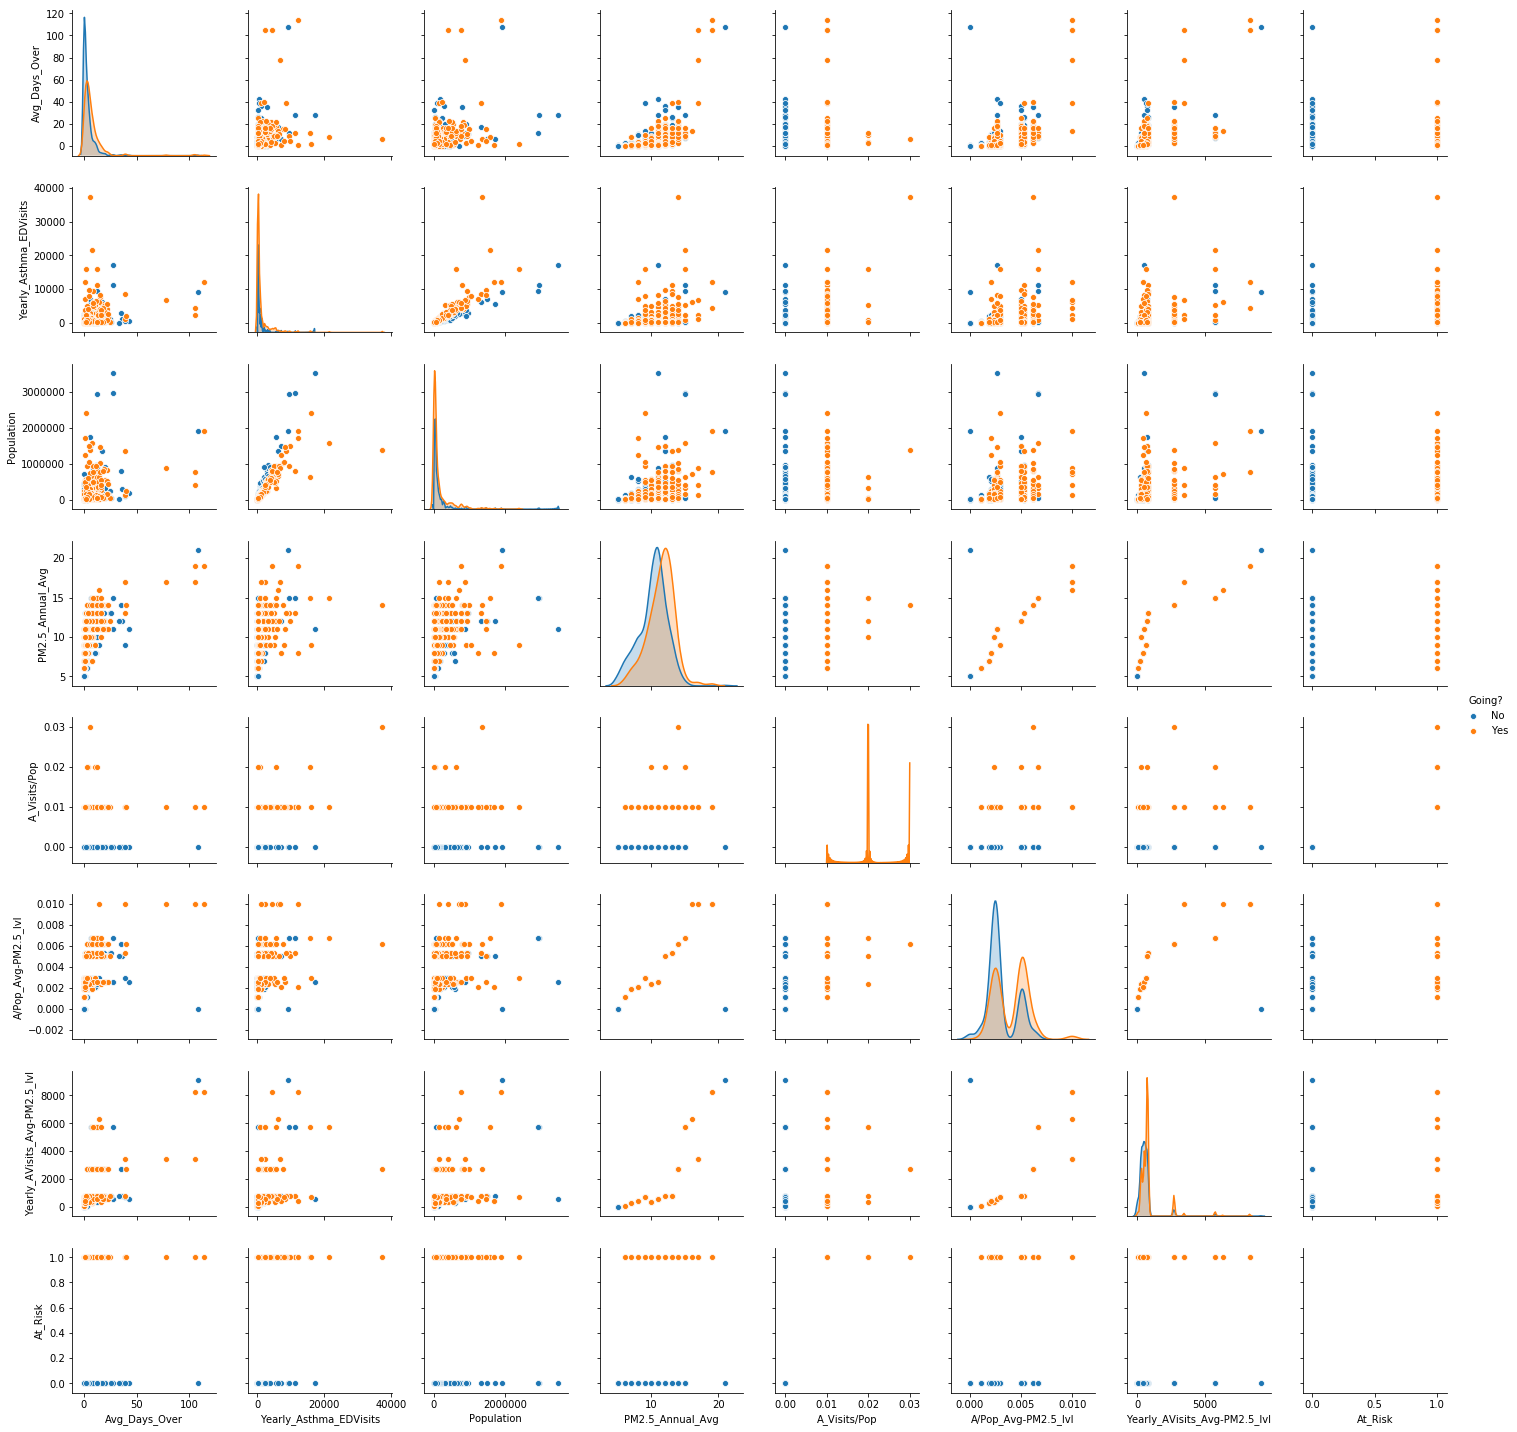

In [79]:
#Identify features that drive model

sns.pairplot(train_df, hue='Going?')

In [81]:

log_reg = LogisticRegressionCV()
log_reg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [82]:
log_reg.score(X_train, y_train)

1.0

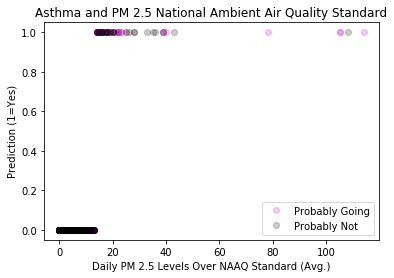

In [291]:
feature = train_df[['Avg_Days_Over']].values
prediction_hard = log_reg.predict(feature)

visit_mask = (train_df['Going?'] == 'Yes').values

plt.plot(feature[visit_mask], prediction_hard[visit_mask], 'mo', label='Probably Going', alpha=0.2)
plt.plot(feature[~visit_mask], prediction_hard[~visit_mask], 'ko', label='Probably Not', alpha=0.2)
plt.ylim(-0.05, 1.05)
plt.xlabel('Daily PM 2.5 Levels Over NAAQ Standard (Avg.)')
plt.ylabel('Prediction (1=Yes)')
plt.title('Asthma and PM 2.5 National Ambient Air Quality Standard')
plt.legend(loc='lower right');
#sns_plot.savefig("Asthma_Avg.svg")

#### Hard Cut Off: 14-16 PM 2.5

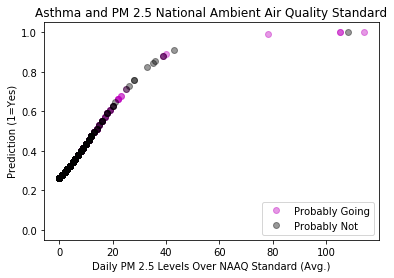

In [753]:
prediction_soft = log_reg.predict_proba(feature)[:, 1]

plt.plot(feature[visit_mask], prediction_soft[visit_mask], 'mo', label='Probably Going',alpha=0.4)
plt.plot(feature[~visit_mask], prediction_soft[~visit_mask], 'ko', label='Probably Not',alpha=0.4)
plt.ylim(-0.05, 1.05)
plt.xlabel('Daily PM 2.5 Levels Over NAAQ Standard (Avg.)')
plt.ylabel('Prediction (1=Yes)')
plt.title('Asthma and PM 2.5 National Ambient Air Quality Standard')
plt.legend(loc='lower right');

In [754]:
confusion_matrix(y_train, prediction_hard)

array([[673,  28],
       [316,  42]])

## Logistic Regression (All Features)

In [90]:
std_scale = StandardScaler() # Multiple features require scaling

X_train = train_df[['Avg_Days_Over', 'PM2.5_Annual_Avg', 'Yearly_AVisits_Avg-PM2.5_lvl','Yearly_Asthma_EDVisits', 'A/Pop_Avg-PM2.5_lvl']]
X_test = test_df[['Avg_Days_Over', 'PM2.5_Annual_Avg', 'Yearly_AVisits_Avg-PM2.5_lvl', 'Yearly_Asthma_EDVisits', 'A/Pop_Avg-PM2.5_lvl']]
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

log_reg4 = LogisticRegressionCV()
log_reg4.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

### Hard Prediction

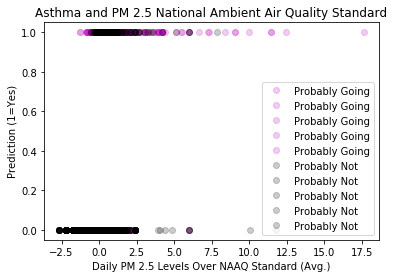

In [91]:
feature = X_train_scaled
prediction_hard = log_reg4.predict(feature)

visit_mask = (train_df['Going?'] == 'Yes').values

plt.plot(feature[visit_mask], prediction_hard[visit_mask], 'mo', label='Probably Going', alpha=0.2)
plt.plot(feature[~visit_mask], prediction_hard[~visit_mask], 'ko', label='Probably Not', alpha=0.2)
plt.ylim(-0.05, 1.05)
plt.xlabel('Daily PM 2.5 Levels Over NAAQ Standard (Avg.)')
plt.ylabel('Prediction (1=Yes)')
plt.title('Asthma and PM 2.5 National Ambient Air Quality Standard')
plt.legend(loc='lower right');

### Soft Prediction

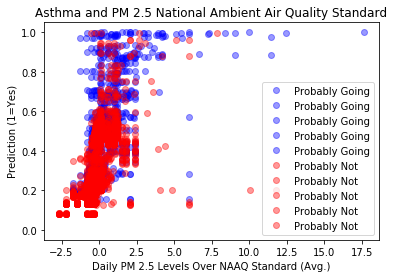

In [99]:
prediction_soft = log_reg4.predict_proba(feature)[:, 1]

plt.plot(feature[visit_mask], prediction_soft[visit_mask], 'bo', label='Probably Going',alpha=0.4)
plt.plot(feature[~visit_mask], prediction_soft[~visit_mask], 'ro', label='Probably Not',alpha=0.4)
plt.ylim(-0.05, 1.05)
plt.xlabel('Daily PM 2.5 Levels Over NAAQ Standard (Avg.)')
plt.ylabel('Prediction (1=Yes)')
plt.title('Asthma and PM 2.5 National Ambient Air Quality Standard')
plt.legend(loc='lower right');

In [96]:
confusion_matrix(y_train, prediction_hard)


array([[646,  55],
       [240, 118]])

In [95]:
log_reg4.score(X_train_scaled, y_train)

0.7214353163361662

In [93]:
log_reg4.coef_

array([[ 0.17423326,  0.00579759, -0.45886629,  0.88123213,  0.77702874]])

In [773]:
coeff_list = list(zip(log_reg4.coef_.reshape(-1), X_test.columns.values))

sorted(coeff_list, key = lambda x: x[0])

[(-0.4588662945785976, 'Yearly_AVisits_Avg-PM2.5_lvl'),
 (0.005797591444663796, 'PM2.5_Annual_Avg'),
 (0.17423326064194922, 'Avg_Days_Over'),
 (0.7770287358881555, 'A/Pop_Avg-PM2.5_lvl'),
 (0.8812321262412751, 'Yearly_Asthma_EDVisits')]

In [177]:
decisiontree = DecisionTreeClassifier(max_depth=1)
decisiontree.fit(X_train_scaled, y_train)
decisiontree.score(X_test, y_test)

0.6754716981132075

In [164]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train_scaled, y_train)
randomforest.score(X_test, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.4188679245283019

In [165]:
linearsvc = LinearSVC()
linearsvc.fit(X_train_scaled, y_train)
linearsvc.score(X_test, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7169811320754716

In [170]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_scaled, y_train)
knn.score(X_test, y_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.7132075471698113

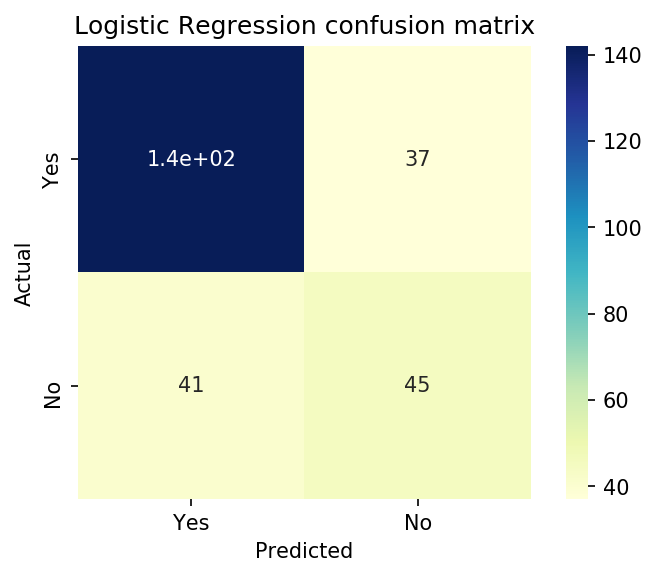

In [774]:
labels = ['Yes', 'No']
logit_confusion = confusion_matrix(y_test, log_reg4.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.YlGnBu, annot=True, square=True,
           xticklabels=labels,
           yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression confusion matrix');

# KNN

In [775]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

The score for kNN is
Training:  33.99%
Test set:  33.58%


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


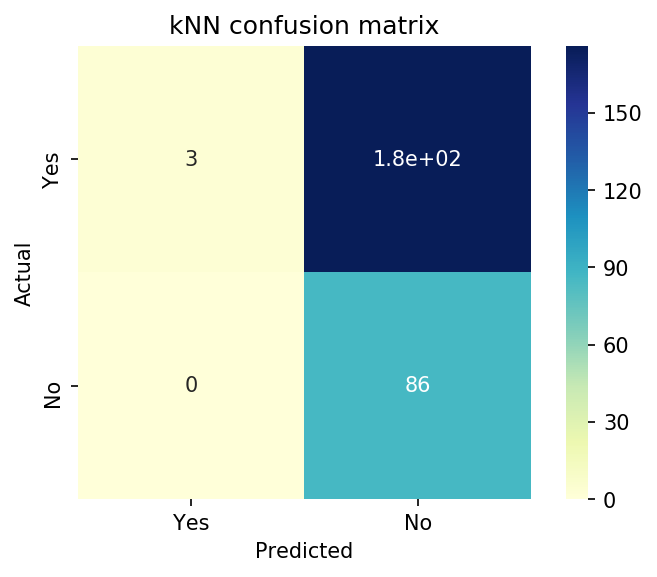

In [776]:
# Print confusion matrix for kNN
labels = ['Yes', 'No']
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.YlGnBu, annot=True, square=True,
           xticklabels=labels,
           yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

At Threshold .5


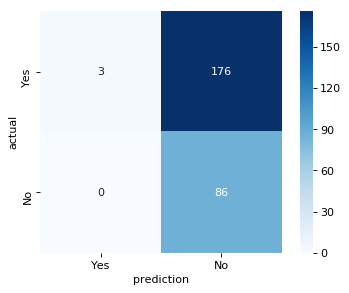

In [777]:
print('At Threshold .5')
make_confusion_matrix(knn)

At Threshold .75


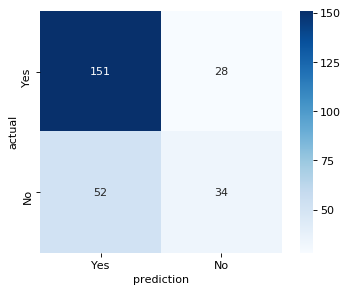

In [778]:
print('At Threshold .75')
make_confusion_matrix(knn, .75)

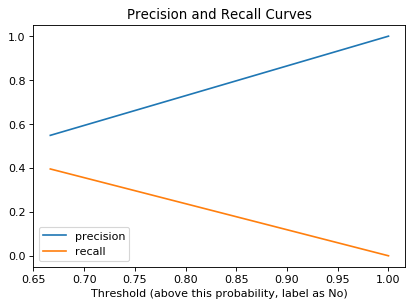

In [779]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, knn.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as No)');
plt.title('Precision and Recall Curves');

In [279]:
new_united10['Going?'] = new_united10['At_Risk'].apply(lambda x: (x and 'Yes') or 'No')

In [284]:
#new_united10.drop('Going?', axis=1,inplace=True)

# Class Imbalance

[Text(0, 0.5, 'Samples')]

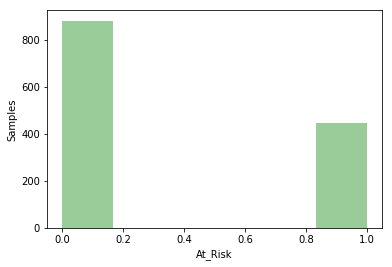

In [47]:
#Evidence of class imbalance

sns.distplot(new_united10['At_Risk'], kde=False, color="Green").set(ylabel='Samples')

In [48]:
np.random.seed(42)
total_users = new_united10['PM2.5_Annual_Avg'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20))

df_X_tr, df_X_te = new_united10[~new_united10['PM2.5_Annual_Avg'].isin(test_users)], new_united10[new_united10['PM2.5_Annual_Avg'].isin(test_users)]

y_tr, y_te = df_X_tr['At_Risk'], df_X_te['At_Risk']
X_tr, X_te = df_X_tr.drop(['A_Visits/Pop','Population', 'At_Risk'],axis=1), \
             df_X_te.drop(['A_Visits/Pop','Population', 'At_Risk'],axis=1), \

### Resampling The Data

In [294]:
import imblearn.over_sampling

n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 
smote = imblearn.over_sampling.SMOTE(ratio=ratio, random_state = 42)

X_tr_smote, y_tr_smote = smote.fit_sample(X_tr, y_tr)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_smote.predict(X_te)), roc_auc_score(y_te, lr_smote.predict_proba(X_te)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.547, Test AUC: 0.754


/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1776) in class 1 will be larger than the number of samples in the majority class (class #0 -> 880)
  n_samples_majority))


In [317]:
ROS = imblearn.over_sampling.RandomOverSampler(ratio = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_tr, y_tr)

lr = LogisticRegression(solver='liblinear') 
lr.fit(X_tr, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr.predict(X_te)), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))) 

lr_os = LogisticRegression(solver='liblinear') 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_os.predict(X_te)), roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1])))

Simple Logistic Regression; Test F1: 0.372, Test AUC: 0.765
Logistic Regression on Oversampled Train Data; Test F1: 0.514, Test AUC: 0.771


/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1776) in class 1 will be larger than the number of samples in the majority class (class #0 -> 522)
  n_samples_majority))
/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (880) in class 0 will be larger than the number of samples in the majority class (class #0 -> 522)
  n_samples_majority))


In [288]:
lr_os.score(X_te, y_te)

1.0

In [277]:
X_te.head()

,Avg_Days_Over,Yearly_Asthma_EDVisits,PM2.5_Annual_Avg,A/Pop_Avg-PM2.5_lvl,Yearly_AVisits_Avg-PM2.5_lvl
0,114.0,12050.0,19.0,0.01,8262.0
1,105.0,4473.0,19.0,0.01,8262.0
2,108.0,9079.0,21.0,0.00,9079.0
3,105.0,2388.0,17.0,0.01,3439.0
4,78.0,6759.0,17.0,0.01,3439.0


In [319]:
lr_balanced.fit(X_tr_rs, y_tr_rs)
print("Score:",lr_balanced.score(X_te, y_te))
#print("Hard Predictions:", lr_balanced.predict(X_te))
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_balanced.predict(X_te)), roc_auc_score(y_te, lr_balanced.predict_proba(X_te)[:,1])))

Score: 0.6697588126159555
Balanced class weights Logistic Regression Test F1: 0.606, Test AUC: 0.770


In [325]:
df_X_tr[['Avg_Days_Over']].shape

(785, 1)

([array([224., 112.,  59., 236., 881., 617., 310., 182.,  35.,   0.]),
  array([  0.,  35., 182., 310., 617., 881., 236.,  59., 112., 224.])],
 array([1.27498012e-09, 1.00000001e-01, 2.00000001e-01, 3.00000001e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 6.99999999e-01,
        7.99999999e-01, 8.99999999e-01, 9.99999999e-01]),
 <a list of 2 Lists of Patches objects>)

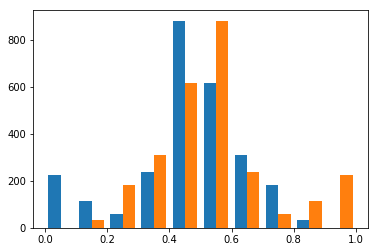

In [327]:
plt.hist(lr_balanced.predict_proba(X_tr_rs))

In [304]:
feature = X_tr_rs[['Avg_Days_Over']].values
prediction_hard = lr_balanced.predict(feature)

X_tr_rs['Going?'] = df_X_tr['At_Risk'].apply(lambda x: (x and 'Yes') or 'No')
visit_mask = (X_tr_rs['Going?'] == 'Yes').values

plt.plot(feature[visit_mask], prediction_hard[visit_mask], 'mo', label='Probably Going', alpha=0.2)
plt.plot(feature[~visit_mask], prediction_hard[~visit_mask], 'ko', label='Probably Not', alpha=0.2)
plt.ylim(-0.05, 1.05)
plt.xlabel('Daily PM 2.5 Levels Over NAAQ Standard (Avg.)')
plt.ylabel('Prediction (1=Yes)')
plt.title('Asthma and PM 2.5 National Ambient Air Quality Standard')
plt.legend(loc='lower right');

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [339]:
decisiontree = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
decisiontree.fit(X_tr_rs, y_tr_rs)
print('Score:',decisiontree.score(X_te, y_te))
print('Balanced class weights DecisionTree Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, decisiontree.predict(X_te)), roc_auc_score(y_te, decisiontree.predict_proba(X_te)[:,1])))

Score: 0.6957328385899815
Balanced class weights DecisionTree Test F1: 0.637, Test AUC: 0.767


In [321]:
randomforest = RandomForestClassifier(bootstrap=True)
randomforest.fit(X_tr_rs, y_tr_rs)
print('Score',randomforest.score(X_te, y_te))
print('Balanced class weights DecisionTree Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, randomforest.predict(X_te)), roc_auc_score(y_te, randomforest.predict_proba(X_te)[:,1])))

Score 0.6771799628942486
Balanced class weights DecisionTree Test F1: 0.511, Test AUC: 0.697


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [333]:
linearsvc = LinearSVC()
linearsvc.fit(X_tr_rs, y_tr_rs)
linearsvc.score(X_te, y_te)
print('Balanced class weights DecisionTree Test F1: %.3f, Test AUC: %.3f',(f1_score(y_te, linearsvc.predict(X_te))))

Balanced class weights DecisionTree Test F1: %.3f, Test AUC: %.3f 0.5027777777777779


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [323]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_tr_rs, y_tr_rs)
print("Score:",knn.score(X_te, y_te))
print('Balanced class weights DecisionTree Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, knn.predict(X_te)), roc_auc_score(y_te, knn.predict_proba(X_te)[:,1])))

Score: 0.6586270871985158
Balanced class weights DecisionTree Test F1: 0.566, Test AUC: 0.701


### During Model Training - Class Weights

In [184]:
lr = LogisticRegression(solver='liblinear') 
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_4x = LogisticRegression(class_weight={1 : 2, 0 : 1}, solver='liblinear')

lr.fit(X_tr, y_tr)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr.predict(X_te)), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1])))

lr_balanced.fit(X_tr, y_tr)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_balanced.predict(X_te)), roc_auc_score(y_te, lr_balanced.predict_proba(X_te)[:,1])))

lr_4x.fit(X_tr, y_tr)
print('3:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_4x.predict(X_te)), roc_auc_score(y_te, lr_4x.predict_proba(X_te)[:,1])))

Normal Logistic Regression Test F1: 0.325, Test AUC: 0.746
Balanced class weights Logistic Regression Test F1: 0.601, Test AUC: 0.747
3:1 class weights Logistic Regression Test F1: 0.609, Test AUC: 0.746


### Choosing Balanced

In [813]:
lr_balanced.coef_

array([[ 2.58479136e-02,  5.31685743e-04,  2.23884623e-01,
         2.18312387e-02, -2.17351272e-04]])

In [814]:
coeff_list = list(zip(lr_balanced.coef_.reshape(-1), X_te.columns.values))

sorted(coeff_list, key = lambda x: x[0])

[(-0.00021735127159458811, 'Yearly_AVisits_Avg-PM2.5_lvl'),
 (0.0005316857430980558, 'Yearly_Asthma_EDVisits'),
 (0.021831238719098534, 'A/Pop_Avg-PM2.5_lvl'),
 (0.02584791364197506, 'Avg_Days_Over'),
 (0.22388462254964506, 'PM2.5_Annual_Avg')]

In [ ]:
sns.pairplot(train_df, hue='Going?')

### After Model Training - Threshold Adjustment to Optimize F1

Logistic Regression Model best F1 score 0.610 at prob decision threshold >= 0.337


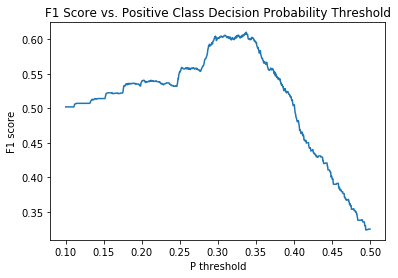

In [783]:
X_val, y_val = X_te, y_te # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lr.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

# RandomForest, DecisionTree, and LinearSVC

In [785]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

linearsvc = LinearSVC()
X = new_united10[['Avg_Days_Over', 'PM2.5_Annual_Avg', 'Yearly_AVisits_Avg-PM2.5_lvl', 'Yearly_Asthma_EDVisits', 'A/Pop_Avg-PM2.5_lvl']]
y = new_united10['At_Risk']
# Do the test 10 times with a LinearSVC and get the average score
quick_test_afew_times(linearsvc, X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6728643216080401

In [791]:
decisiontree = DecisionTreeClassifier(max_depth=3)
quick_test_afew_times(decisiontree, X, y)

0.7208542713567839

In [787]:
randomforest = RandomForestClassifier()
quick_test_afew_times(randomforest, X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7085427135678392

# Xgboost

In [ ]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [ ]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

In [ ]:
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

In [ ]:
rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val) 

# What is PM2.5 and Why You Should Care (Facts and Notes)

* PM2.5 refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers, which is about 3% the diameter of a human hair.

* can only be detected with an electron microscope

* They are even smaller than their counterparts PM10, which are particles that are 10 micrometres or less, and are also called fine particles.

* Some are emitted directly into the air, while others are formed when gases and particles interact with one another in the atmosphere.

* For instance, gaseous sulfur dioxide emitted from power plants reacts with oxygen and water droplets in the air to form sulfuric acid as a secondary particle.

* Since they are so small and light, fine particles tend to stay longer in the air than heavier particles. This increases the chances of humans and animals inhaling them into the bodies. Owing to their minute size, particles smaller than 2.5 micrometers are able to bypass the nose and throat and penetrate deep into the lungs and some may even enter the circulatory system.

* Studies have found a close link between exposure to fine particles and premature death from heart and lung disease. Fine particles are also known to trigger or worsen chronic disease such as asthma, heart attack, bronchitis and other respiratory problems.

* long-term exposure to PM2.5 may lead to plaque deposits in arteries, causing vascular inflammation

* a hardening of the arteries which can eventually lead to heart attack and stroke

* study estimated that for every 10 micrograms per cubic meter (μg/m3) increase in fine particulate air pollution, there is an associated 4%, 6% and 8% increased risk of all-cause, cardiopulmonary and lung cancer mortality, respectively.

>>“Exposure to PM <2.5 μm in diameter (PM2.5) over a few hours to weeks can trigger cardiovascular disease-related mortality and nonfatal events; longer-term exposure (eg, a few years) increases the risk for cardiovascular mortality to an even greater extent than exposures over a few days and reduces life expectancy within more highly exposed segments of the population by several months to a few years.”

* An association between mothers’ exposure to fine particles and birth defects has also been established by several reports.

### How to Read PM_2.5

* On a very clear and non-hazy day, the PM2.5 concentration can be as low as 5 μg/m3 or below. The 24-hour concentration of PM2.5 is considered unhealthy when it rises above 35.4 μg/m3.

* the potential damage caused by air pollutants depends not just on the concentration, but also on the duration of exposure. The longer you are exposed to PM2.5, the higher the risk of developing adverse effects caused by the exposure.

## Measure Names

1- 'Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard'

2- 'Number of person-days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard'

3- 'Person-days with PM2.5 over the National Ambient Air Quality Standard'

4- 'Percent of days with PM2.5 levels over the National Ambient Air Quality Standard (NAAQS)'

5- 'Annual average ambient concentrations of PM2.5 in micrograms per cubic meter (based on seasonal averages and daily measurement)'

6- 'Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data)'

7- 'Number of person-days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data)

8- 'Percent of days with PM2.5 levels over the National Ambient Air Quality Standard (monitor and modeled data)

9- 'Number of person-days with PM2.5 over the National Ambient Air Quality Standard (monitor and modeled data)'

10 'Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter, based on seasonal averages and daily measurement (monitor and modeled data)'

#### 8 hour info

https://www3.epa.gov/region1/airquality/avg8hr.html

# Source

https://data.cdc.gov/Environmental-Health-Toxicology/Air-Quality-Measures-on-the-National-Environmental/cjae-szjv

Air Quality Measures on the National Environmental Health Tracking Network

https://apps.health.ny.gov/statistics/environmental/public_health_tracking/tracker/index.html#/asthmaExportData

NYS Department of Health (Export Asthma Data)

# Asthma

* Most costly chronis diseases. $50 billion annually in direct medical expenditures in the United States
